In [1]:
%matplotlib inline
import sys
sys.path.append("..")

In [2]:
import random

import deeptrack as dt

import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf

tracker_input_size = 52

In [3]:
# model = AutoTracker()

class CrescentMoon(dt.Ellipse):
    def get(self, *inp, radius, offset, **kwargs):
        ellipse = super().get(*inp, radius=radius, **kwargs)
        offset = np.round(offset).astype(np.int)
        other = dt.Affine(translate=offset, mode="constant").resolve(ellipse)
        ellipse[np.array(other > 0)] = 0
        
        return ellipse
        
class Rectangle(dt.Scatterer):
    def get(self, *inp, width, height, **kwargs):
        return np.ones((round(width), round(height), 1))
        

In [4]:

commons = dt.DummyFeature(
    image_size=tracker_input_size,
    position=lambda image_size: image_size / 2 + np.random.randn(2) * 2
)

arguments = dt.Arguments(
    noise_level=lambda: 2 + np.random.rand() * 18,
    key=lambda: np.random.choice(["moon", "rect", "ellipse"]),
)

fluorescence_microscope = dt.Fluorescence(
    NA=0.8,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, tracker_input_size, tracker_input_size)
)

noise = dt.Poisson(snr=arguments.noise_level, background=0.2)

u = dt.units
moon_particle = CrescentMoon(radius=1e-6, offset=(6, 0), position=commons.position)
rectangle_particle = Rectangle(height=18, width=12, position=commons.position)
ellipse_particle = dt.Sphere(radius=0.1 * u.um, position=commons.position)

particles = {
    "moon": moon_particle,
    "rect": rectangle_particle,
    "ellipse": ellipse_particle
}

particle = dt.OneOfDict(particles, key=arguments.key)

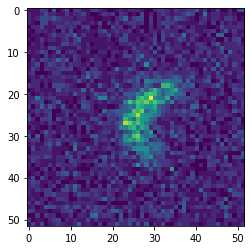

In [5]:


pipeline = (
    fluorescence_microscope(particle)
    >> dt.Affine(rotate=lambda:np.random.rand() * 2 * np.pi)
    >> dt.NormalizeMinMax() 
    + 0.2
) >> noise >> dt.NormalizeMinMax()

pipeline.bind_arguments(arguments)
pipeline.update().plot()

In [6]:
dataset = [pipeline.update().resolve() for _ in range(1000)]
dataset_labels = [np.mean(d.get_property("position", get_one=False), axis=0) for d in dataset]

In [7]:
def plot(xraw, diff, **kwargs):

    vmin = np.min(xraw)
    vmax = np.max(xraw)
    npoints = 10
    x = np.linspace(vmin, vmax, npoints)

    _x = xraw
    _y = np.abs(diff - np.mean(diff, axis=0))
    
    

    y = np.array([np.mean( _y[(_x >= x[i]) & (_x < x[i+1]) ], axis=0) for i in range(npoints-1)])

    plt.subplot(1, 3, 2)
    plt.plot(x[:npoints-1], y[:npoints-1, 0], **kwargs)
    plt.yscale("log")

    plt.title("Tracking error x")
    plt.ylabel(f"Absolute prediction error")
    plt.xlabel(f"Signal to noise")


    plt.subplot(1, 3, 3)
    plt.plot(x[:npoints-1], y[:npoints-1, 1], **kwargs)
    plt.yscale("log")

    plt.title("Tracking error y")
    plt.ylabel(f"Absolute prediction error")
    plt.xlabel(f"Signal to noise")


In [9]:
from deeptrack.extras.radialcenter import radialcenter

symmetries = 1
key = "rect"
noise_level = 5

model = dt.models.AutoMultiTracker(
    input_shape=(None, None, 1),
    mode="tracking",
    symmetries=symmetries,
)


model_data = dt.Value(pipeline.update().resolve(key=key, noise_level=noise_level))

model.predict(model_data[np.newaxis]())
model.model.save("model")
print(type(model.model), model.model.name_scope)
model = tf.keras.models.load_model("model", custom_objects={"AutoTrackerModel": dt.models.AutoMultiTracker.AutoTrackerModel})
print(type(model))
model.predict(model_data[np.newaxis, :50, :50]())

INFO:tensorflow:Assets written to: model\assets
<class 'deeptrack.models.autotrack.AutoMultiTracker.AutoTrackerModel'> <bound method Layer._name_scope of <deeptrack.models.autotrack.AutoMultiTracker.AutoTrackerModel object at 0x0000018C623E6AF0>>
<class 'deeptrack.models.autotrack.AutoMultiTracker.AutoTrackerModel'>


array([[[[ 0.05244953, -0.05671975],
         [ 0.0733102 ,  3.9486644 ],
         [ 0.08172517,  7.934368  ]],

        [[ 4.0933366 , -0.04014201],
         [ 4.102327  ,  3.9640281 ],
         [ 4.099214  ,  7.93527   ]],

        [[ 8.095937  , -0.02104387],
         [ 8.1022215 ,  3.9785633 ],
         [ 8.090534  ,  7.9464536 ]]]], dtype=float32)

In [ ]:
model.get_config()

NotImplementedError: 

In [ ]:
model.model.input_shape

(None, 52, 52, 1)

Text(0.5, 1.0, 'Model training sample')

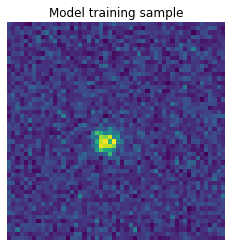

In [ ]:
plt.imshow(model_data())
plt.axis("off")
plt.title("Model training sample")

In [ ]:
# d = model.data_generator(model_data, batch_size=2)

# with d:
#     pass
# x, y = d[0]

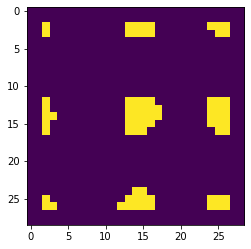

(-0.5, 155.5, 155.5, -0.5)

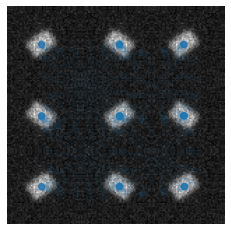

In [ ]:

i = 3
im = np.array(dataset[i:i+2])

im = np.pad(im, [(0, 0), (52, 52), (52, 52), (0, 0)], mode="reflect")

pred = model.predict(im) + 26

import scipy.signal

kernel = np.ones((3, 3)) / 3**2

kernel2 = np.ones((3, 3)) / 3**2

pred_local_x = scipy.signal.convolve2d(pred[0, ..., 0], kernel, "same") ** 2
pred_local_y = scipy.signal.convolve2d(pred[0, ..., 1], kernel, "same") ** 2

squared_pred_local_x = scipy.signal.convolve2d(pred[0, ..., 0] ** 2, kernel, "same")
squared_pred_local_y = scipy.signal.convolve2d(pred[0, ..., 1] ** 2, kernel, "same")

squared_diff = squared_pred_local_x + squared_pred_local_y - (pred_local_x + pred_local_y)
squared_diff = scipy.signal.convolve2d(squared_diff, kernel2, "same")

plt.imshow(1 / (squared_diff + 1e-6) > 0.4)
plt.show()
plt.imshow(im[0], cmap="gray")
pred = np.reshape(pred[0], (-1, 2))
plt.scatter(pred[:, 1], pred[:, 0], alpha=0.05)
plt.axis("off")


# pred = np.reshape(pred[0], (-1, 2))
# plt.scatter(pred[:, 1], pred[:, 0], alpha=0.1)

In [ ]:
pred[0, ..., 0].shape

()

In [ ]:
im2 = 128
commons = dt.DummyFeature(
    image_size=tracker_input_size,
    position=lambda image_size: image_size / 2 + np.random.randn(2) * 2,
    particle_distance=10,
)

arguments = dt.Arguments(
    noise_level=lambda: 2 + np.random.rand() * 18,
    key=lambda: np.random.choice(["moon", "rect", "ellipse"]),
)

fluorescence_microscope = dt.Fluorescence(
    NA=0.8,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, im2, im2)
)

noise = dt.Poisson(snr=arguments.noise_level, background=0.2)

u = dt.units
moon_particle = CrescentMoon(radius=1e-6, offset=(6, 0), position=commons.position)
rectangle_particle = Rectangle(height=18, width=12, position=commons.position)

particle_1 = dt.Sphere(
    radius=.1 * u.um, 
    distance=commons.particle_distance,
    position=lambda distance:im2 / 2 - np.array((0, distance)) / 2
)

particle_2 = dt.Sphere(
    radius=.1 * u.um, 
    distance=commons.particle_distance,
    position=lambda distance:im2 / 2 + np.array((0, distance)) / 2
)

sample = particle_1 & particle_2 

pipeline2 = (
    commons >>
    fluorescence_microscope(sample)
    >> dt.NormalizeMinMax() 
    + 0.2
) >> noise >> dt.NormalizeMinMax()

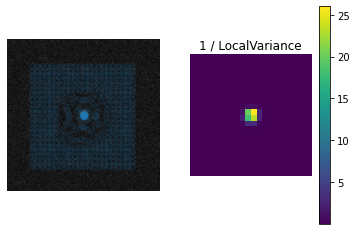

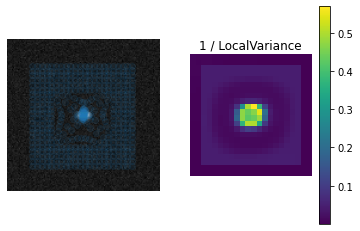

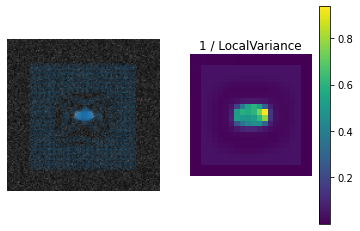

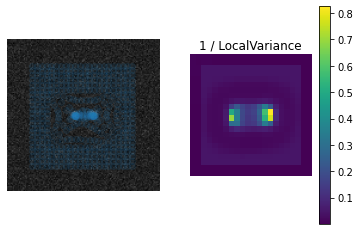

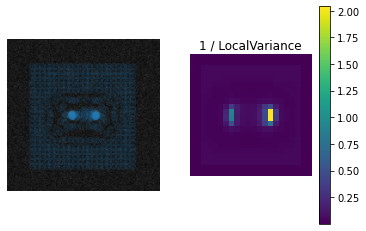

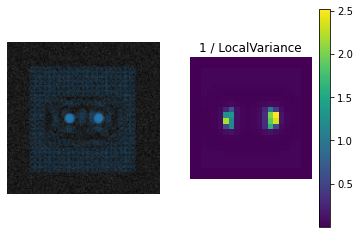

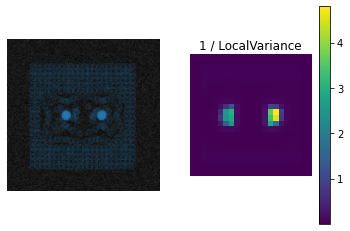

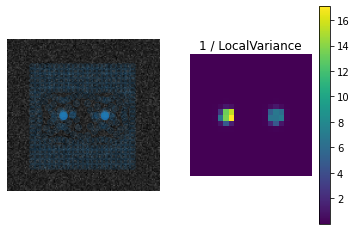

In [ ]:
for distance in range(0, 40, 5):

    im = pipeline2.update().resolve(particle_distance=distance)
    pred = model.predict(np.array([im])) + 26
    
    
    kernel = np.ones((3, 3)) / 3**2

    kernel2 = np.ones((3, 3)) / 3**2

    pred_local_x = scipy.signal.convolve2d(pred[0, ..., 0], kernel, "same") ** 2
    pred_local_y = scipy.signal.convolve2d(pred[0, ..., 1], kernel, "same") ** 2

    squared_pred_local_x = scipy.signal.convolve2d(pred[0, ..., 0] ** 2, kernel, "same")
    squared_pred_local_y = scipy.signal.convolve2d(pred[0, ..., 1] ** 2, kernel, "same")

    squared_diff = squared_pred_local_x + squared_pred_local_y - (pred_local_x + pred_local_y)
    squared_diff = scipy.signal.convolve2d(squared_diff, kernel2, "same")

    pred = np.reshape(pred[0], (-1, 2))
    plt.subplot(1,2,1)
    plt.imshow(im, cmap="gray")
    plt.scatter(pred[:, 1], pred[:, 0], alpha=0.1)
    plt.axis("off")
    plt.subplot(1,2,2)
    
    plt.imshow(1 / (squared_diff + 1e-6))
    plt.axis("off")
    plt.colorbar()
    plt.title("1 / LocalVariance")
    # plt.scatter(pred[:, 1], pred[:, 0], alpha=0.05)
    plt.show()